# EDA

## 0. Setup

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns

In [2]:
DATA_FOLDER_PATH = Path("../../data")
PROCESSED_DATA_FOLDER_PATH = DATA_FOLDER_PATH.joinpath("processed")

## 1. Papers and affiliations

In [25]:
papers_df = pd.read_csv(PROCESSED_DATA_FOLDER_PATH.joinpath("papers.csv"))

In [26]:
paper_to_affiliation_df = pd.read_csv(PROCESSED_DATA_FOLDER_PATH.joinpath("paper_to_affiliation.csv"))

In [27]:
affiliation_count_df = paper_to_affiliation_df.groupby("paper_id")["id"].count().reset_index(name="affiliation_count")

In [29]:
papers_df = papers_df.merge(affiliation_count_df, left_on="id", right_on="paper_id", right_index=False, how="left")

In [30]:
papers_df["affiliation_count"] = papers_df["affiliation_count"].fillna(0)

<Axes: ylabel='Count'>

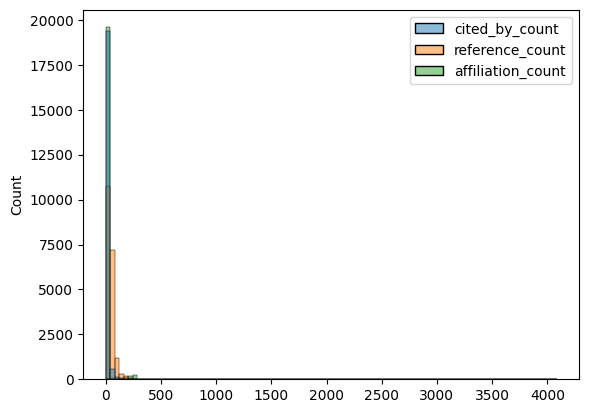

In [33]:
sns.histplot(papers_df, bins=100)

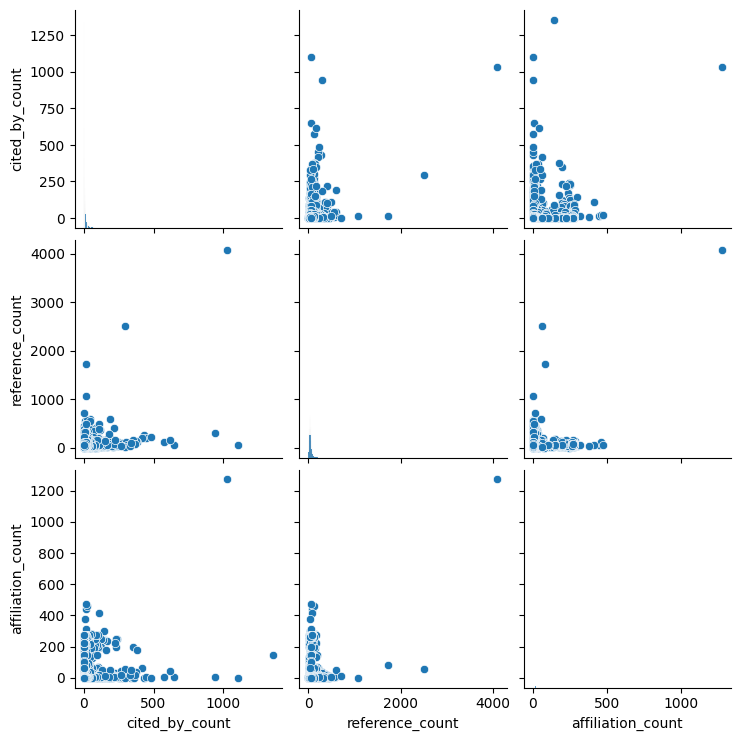

In [31]:
sns.pairplot(papers_df)

<Axes: >

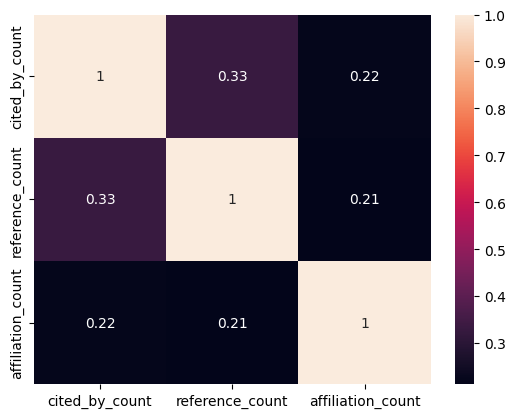

In [35]:
sns.heatmap(papers_df.select_dtypes(include="number").corr(), annot=True)

## 2. Classification codes

In [144]:
classification_codes_df = pd.read_csv(PROCESSED_DATA_FOLDER_PATH.joinpath("classification_codes.csv"))

In [147]:
classification_codes_df

,name,code,abbreviation
0,Medicine (all),2700,MEDI
1,Electrical and Electronic Engineering,2208,ENGI
2,"Electronic, Optical and Magnetic Materials",2504,MATE
3,Chemistry (all),1600,CHEM
4,Chemical Engineering (all),1500,CENG
...,...,...,...
316,Dental Assisting,3502,DENT
317,Gender Studies,3318,SOCI
318,Occupational Therapy,3609,HEAL
319,Optometry,3610,HEAL


<Axes: xlabel='count', ylabel='abbreviation'>

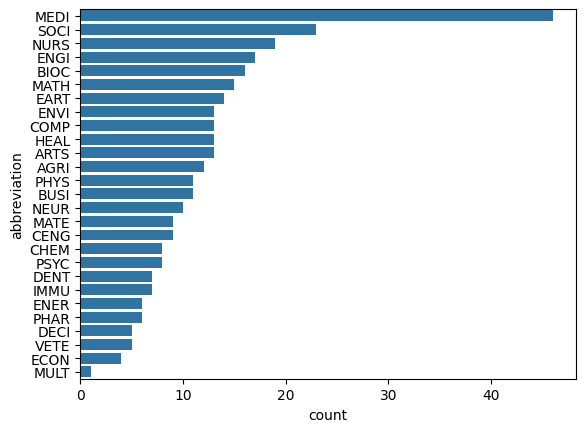

In [149]:
abbreviation_count_df = classification_codes_df.groupby("abbreviation")["code"].count().sort_values(ascending=False).reset_index(name="count")
sns.barplot(x="count", y="abbreviation", data=abbreviation_count_df)

## 3. Keyword co-occurrences

In [3]:
import networkx as nx

In [32]:
paper_to_keyword_df = pd.read_csv(PROCESSED_DATA_FOLDER_PATH.joinpath("paper_to_keyword.csv")).dropna()
paper_to_keyword_df.head(5)

,id,keyword
0,2-s2.0-85052201238,Multiphase flow models
1,2-s2.0-85052201238,Riser
2,2-s2.0-85052201238,Sorption enhanced steam methane reforming
3,2-s2.0-85052201238,Encapsulation
4,2-s2.0-85052201238,Fluoroalkylsilane


In [33]:
keyword_count_df = paper_to_keyword_df.groupby("keyword").count().sort_values(by="id", ascending=False)
keyword_count_df.head(5)

,id
keyword,
Thailand,713
COVID-19,268
Hadron-Hadron scattering (experiments),136
Inflammation,121
HIV,110


In [34]:
keyword_groups = paper_to_keyword_df.groupby("id")["keyword"].apply(list)
keyword_groups.head(5)

id
2-s2.0-84946771902    [thioesterase domain, Adrenal gland volume, fo...
2-s2.0-84946882107    [Synergistic effects, Botulinum toxin therapy,...
2-s2.0-84957541768    [Magneto-electronics, recording head, tunnelin...
2-s2.0-84963739401    [Hydroxyl terminated natural rubber, Poly(lact...
2-s2.0-84973402286    [Thailand, Work-related musculoskeletal disord...
Name: keyword, dtype: object

In [45]:
G = nx.Graph()

for keyword_group in keyword_groups:
    G.add_nodes_from(keyword_group)
    for idx1, keyword1 in enumerate(keyword_group):
        keyword1 = keyword1.lower()
        for idx2, keyword2 in enumerate(keyword_group[idx1+1:], idx1+1):
            keyword2 = keyword2.lower()
            if G.has_edge(keyword1, keyword2):
                G[keyword1][keyword2]["weight"] += 1
            else:
                G.add_edge(keyword1, keyword2, weight=1)

In [46]:
keyword_to_degree = pd.Series(dict(G.degree())).sort_values(ascending=False)
keyword_to_degree.head(5)

thailand            2674
covid-19            1066
machine learning     544
inflammation         503
sars-cov-2           439
dtype: int64

<Axes: ylabel='None'>

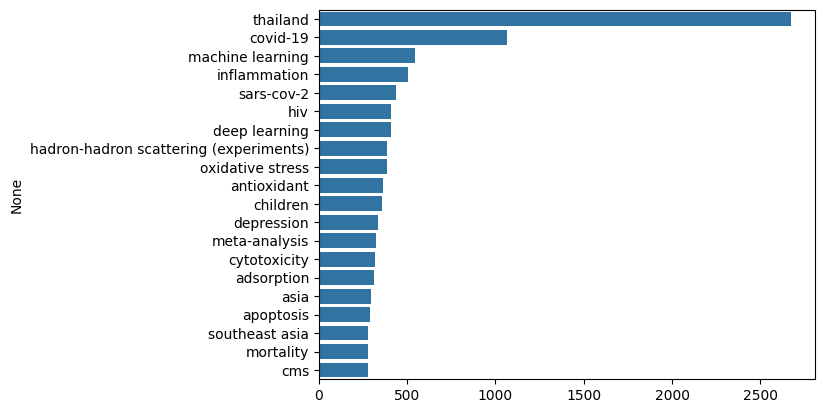

In [47]:
sns.barplot(x=keyword_to_degree.head(20).values, y=keyword_to_degree.head(20).index)

In [100]:
keyword_pagerank_centralities = pd.DataFrame.from_dict(
    nx.pagerank(G), orient="index", columns=["pagerank_centrality"]
).sort_values("pagerank_centrality", ascending=False)
keyword_pagerank_centralities.head(5)

,pagerank_centrality
Thailand,0.006837
COVID-19,0.002494
Hadron-Hadron scattering (experiments),0.001008
SARS-CoV-2,0.000975
HIV,0.000963


In [82]:
communities = nx.community.louvain_communities(G, weight="weight", seed=56164)

In [137]:
communities[1147]

{'2-person game',
 '3D scanning system',
 '6-minute walk test',
 '8-bit soft microprocessor',
 'AISI 316L',
 'AMD risk factors',
 'AS',
 'ASEAN composition',
 'ASEAN drum',
 'Abdominal fat',
 'Acid sites control',
 'Acid transformation',
 'Acronychia pedunculata',
 'Active break',
 'Activity Profiles',
 'Activity-tracking devices',
 'Adaptive optics',
 'Adaptive washout filter',
 'Ageing',
 'Agricultural waste management',
 'Al-SBA-15',
 'Ala nasi',
 'Alantolactone',
 'Algebraic degree',
 'Alternative functional equations',
 'Amateur Boxing',
 'Andersen model',
 'Android applications',
 'Antifungal drug-resistance',
 'Antitumor',
 'Areal density',
 'Arm swing exercise',
 'Asian business',
 'Atraumatic restorative treatment',
 'Baeckea frutescens',
 'Bax/Bcl-2',
 'Berg Balance Scale',
 'Binary event',
 'Biodiesel waste',
 'Bladder diary',
 'Blattodea',
 'Blood meal source',
 'Blood pressure',
 'Body mass index',
 'Bolus',
 'Bone healing',
 'Bone histomorphometry',
 'Bootstrap',
 'Brachy

In [102]:
keyword_to_community = pd.DataFrame.from_dict({
    keyword: idx
    for idx, community in enumerate(communities)
    for keyword in community
}, orient="index", columns=["community"])

In [112]:
community_max_pagerank_centralities = keyword_pagerank_centralities.join(keyword_to_community).reset_index(names=["keyword"]).groupby("community").agg(
    {"pagerank_centrality": "max"}
).sort_values("pagerank_centrality", ascending=False)
community_max_pagerank_centralities.head(10)

,pagerank_centrality
community,
249,0.006837
147,0.002494
7,0.001008
63,0.000963
991,0.000836
636,0.000735
1296,0.000663
252,0.000601
18,0.000578


In [136]:
x = keyword_pagerank_centralities.join(keyword_to_community).reset_index(names=["keyword"])
x.sort_values(["pagerank_centrality"], ascending=False).groupby("community").first().sort_values("pagerank_centrality", ascending=False).head(50)

,keyword,pagerank_centrality
community,,
249,Thailand,0.006837
147,COVID-19,0.002494
7,Hadron-Hadron scattering (experiments),0.001008
63,HIV,0.000963
991,Inflammation,0.000836
636,CMS,0.000735
1296,Machine learning,0.000663
252,Adsorption,0.000601
18,inflammation,0.000578


In [65]:
# Kagamine
len("rin")

3